In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import re
from itertools import chain

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Load the observations dataset
species =  pd.read_csv('species_info.csv')
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [3]:
# Load the observations dataset
observations =  pd.read_csv('observations.csv')
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


### Data Characteristics and Cleaning

---
#### Species File


In [6]:
# Check the dimensions of the species dataset (rows and columns)
print(f'Species (rows, columns) = {species.shape}')

Species (rows, columns) = (5824, 4)


In [7]:
# Count the number of unique species 
print(f'Number of Species: {species.scientific_name.nunique()}')

Number of Species: 5541


In [8]:
# Check for missing values in species dataset
print(f'Species file missing Values: \n{species.isnull().sum()} \n') 
# Check for duplicated rows in species dataset
print(f'Species file duplicated Values: \n{species.duplicated().sum()}')

Species file missing Values: 
category                  0
scientific_name           0
common_names              0
conservation_status    5633
dtype: int64 

Species file duplicated Values: 
0


In [9]:
# Explore the conservation_status column
print(f'Conservation Status ({species.conservation_status.nunique()}) : {species.conservation_status.unique()} \n')

Conservation Status (4) : [nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery'] 



In [10]:
# Fill missing values in the conservation_status column with "No Intervention"
species.fillna('No Intervention', inplace = True)

In [11]:
# Explore the categories column
print(f'Categories ({species.category.nunique()}) : {species.category.unique()} \n')

Categories (7) : ['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant'] 



##### Cleaning the rows with same scientific_name

In [13]:
new_rows = []
for _, row in species.iterrows():
    common_names = row['common_names'].split(',')
    for name in common_names:
        new_row = row.copy()  
        new_row['common_names'] = name  
        new_rows.append(new_row)

species = pd.DataFrame(new_rows)

species.duplicated().sum()

115

In [14]:
species.drop_duplicates(inplace = True)

species = species.groupby(['category', 'scientific_name', 'conservation_status'], as_index=False, sort = False)['common_names'].apply(lambda x: ', '.join(x))
species = species[['category', 'scientific_name', 'common_names', 'conservation_status']]
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention
1,Mammal,Bos bison,"American Bison, Bison",No Intervention
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), ...",No Intervention
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (...",No Intervention
4,Mammal,Cervus elaphus,"Wapiti Or Elk, Rocky Mountain Elk",No Intervention


---
#### Observations file


In [16]:
# Check the dimensions of the species dataset (rows and columns)
print(f'Observations (rows, columns) = {observations.shape}')

Observations (rows, columns) = (23296, 3)


In [17]:
# Count the number o observations
print(f'Number of Observations: {observations.observations.sum()}')

Number of Observations: 3314739


In [18]:
# Check for missing values in observations dataset
print(f'Observations file missing Values: \n{observations.isnull().sum()} \n')
# Check for duplicated rows in observations dataset
print(f'Observations file duplicated Values: \n{observations.duplicated().sum()}')

Observations file missing Values: 
scientific_name    0
park_name          0
observations       0
dtype: int64 

Observations file duplicated Values: 
15


In [19]:
# Drop duplicated rows from the observations dataset
observations.drop_duplicates(inplace = True)

In [20]:
# Explore the park_name column 
print(f'Parks ({observations.park_name.nunique()}) : {observations.park_name.unique()} \n')

Parks (4) : ['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park'] 



### Analysis

In [22]:
categories_distribution = species.groupby('category').size()
categories_distribution

category
Amphibian              79
Bird                  488
Fish                  126
Mammal                177
Nonvascular Plant     333
Reptile                78
Vascular Plant       4262
dtype: int64

In [23]:
conservation_distribution = species.groupby('conservation_status')['scientific_name'].nunique()

In [24]:
total_observations_by_park = observations.groupby('park_name')['observations'].sum()
total_observations_by_park

park_name
Bryce National Park                     575901
Great Smoky Mountains National Park     431378
Yellowstone National Park              1442314
Yosemite National Park                  862836
Name: observations, dtype: int64

In [25]:
species_by_park = observations.groupby('park_name')['scientific_name'].nunique()
species_by_park

park_name
Bryce National Park                    5541
Great Smoky Mountains National Park    5541
Yellowstone National Park              5541
Yosemite National Park                 5541
Name: scientific_name, dtype: int64

In [26]:
# Filter species with a conservation status other than 'No Intervention'
threatened_data = species[species['conservation_status'] != 'No Intervention']

# Group by 'category' and 'conservation_status', and count unique species
conservation_by_category = (
    threatened_data.groupby(['category', 'conservation_status'])
    ['scientific_name'].nunique()
    .unstack()
)


conservation_by_category

conservation_status,Endangered,In Recovery,Species of Concern,Threatened
category,,,,
Amphibian,1.0,NaN,4.0,2.0
Bird,4.0,3.0,68.0,NaN
Fish,3.0,NaN,4.0,4.0
Mammal,6.0,1.0,22.0,2.0
Nonvascular Plant,NaN,NaN,5.0,NaN
Reptile,NaN,NaN,5.0,NaN
Vascular Plant,1.0,NaN,43.0,2.0


In [27]:
chi2_cat, p_val, dof_cat, expected_cat = chi2_contingency(conservation_by_category.fillna(0))
print(f'Conservation status by Category p-value: {p_val:.2e}')

Conservation status by Category p-value: 3.88e-05


<Figure size 1600x1000 with 0 Axes>

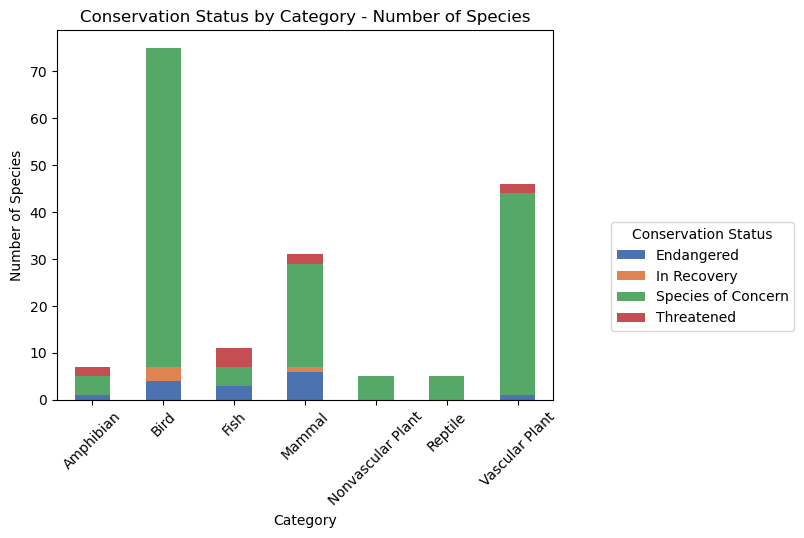

In [28]:
palette = sns.color_palette('deep', n_colors = 4)

plt.figure(figsize=(16,10))
conservation_by_category.plot(kind = 'bar', stacked = True, color = palette)
plt.title('Conservation Status by Category - Number of Species')
plt.xlabel('Category')
plt.ylabel('Number of Species')
plt.tick_params(axis = 'x', rotation = 45)
plt.legend(title = 'Conservation Status', bbox_to_anchor=(1.5, 0.5))

plt.show()

In [29]:
threatened_merged_data = observations.merge(threatened_data, on = 'scientific_name')

obs_by_cat_conservation = (
    threatened_merged_data.groupby(['category', 'conservation_status'])['observations']
    .sum()
    .unstack()
)

obs_by_cat_conservation

conservation_status,Endangered,In Recovery,Species of Concern,Threatened
category,,,,
Amphibian,144.0,NaN,2044.0,564.0
Bird,574.0,1392.0,36642.0,NaN
Fish,455.0,NaN,2109.0,1645.0
Mammal,1463.0,715.0,14408.0,578.0
Nonvascular Plant,NaN,NaN,2705.0,NaN
Reptile,NaN,NaN,2536.0,NaN
Vascular Plant,162.0,NaN,22135.0,552.0


Text(70.72222222222221, 0.5, 'Category')

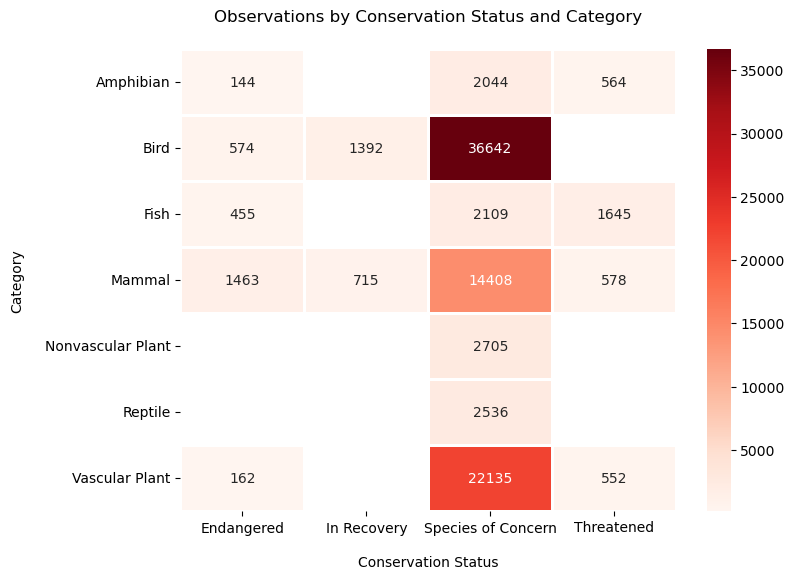

In [100]:
plt.figure(figsize = (8,6))
sns.heatmap(obs_by_cat_conservation, annot = True, fmt='.0f', linewidth=.8, cmap = 'Reds')

plt.title('Observations by Conservation Status and Category', pad = 20)
plt.xlabel('Conservation Status', labelpad = 15)
plt.ylabel('Category', labelpad = 15)

In [31]:
merged_data = species.merge(observations, on = 'scientific_name').sort_values('observations', ascending = False).reset_index(drop = True)
merged_data.head()

,category,scientific_name,common_names,conservation_status,park_name,observations
0,Vascular Plant,Lycopodium tristachyum,"Deep-Root Clubmoss, Ground Cedar",No Intervention,Yellowstone National Park,321
1,Vascular Plant,Castilleja miniata,"Giant Red Indian Paintbrush, Great Red Indian...",No Intervention,Yellowstone National Park,317
2,Vascular Plant,Cryptantha fendleri,"Fendler's Cryptantha, Sanddune Catseye, Sand...",No Intervention,Yellowstone National Park,316
3,Vascular Plant,Dracocephalum parviflorum,American Dragonhead,No Intervention,Yellowstone National Park,316
4,Vascular Plant,Bidens tripartita,"Stick-Tight, Three-Lobe Beggar-Ticks, Threelo...",No Intervention,Yellowstone National Park,314


In [32]:
obs_cat_park = (
    merged_data.groupby(['category', 'park_name'])['observations']
    .sum()
    .unstack()
)
obs_cat_park

park_name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
category,,,,
Amphibian,7380,5707,19440,11444
Bird,51647,37728,126996,76207
Fish,12587,9306,30946,18792
Mammal,20680,15071,50869,30535
Nonvascular Plant,32992,24857,83021,49783
Reptile,7950,5691,19554,11483
Vascular Plant,442959,333177,1112190,664965


Text(70.72222222222221, 0.5, 'Category')

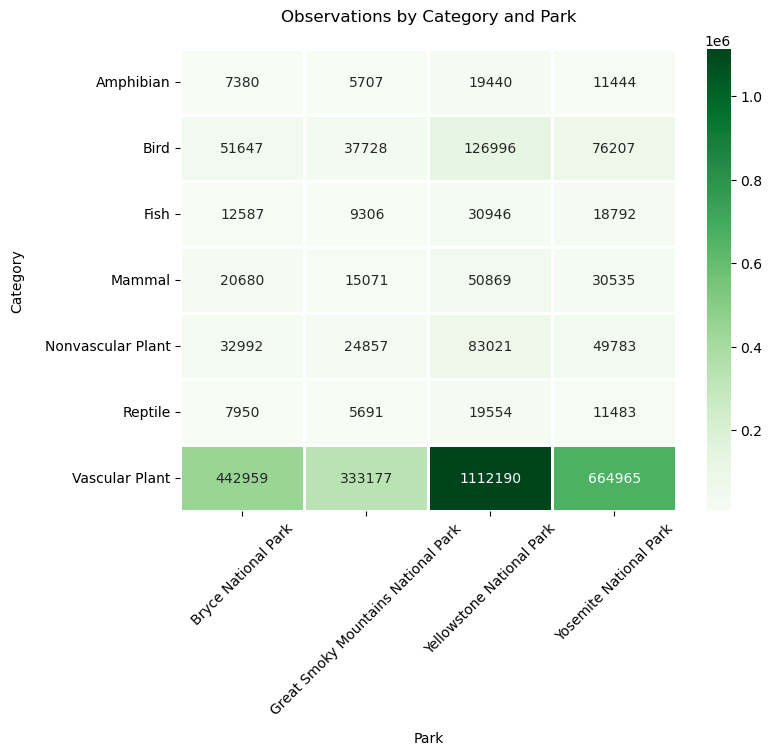

In [98]:
plt.figure(figsize = (8,6))
sns.heatmap(obs_cat_park, annot = True, fmt='.0f', linewidth=.8, cmap = 'Greens')

plt.title('Observations by Category and Park', pad = 20)
plt.xlabel('Park', labelpad = 10)
plt.xticks(rotation = 45)
plt.ylabel('Category', labelpad = 15)

#### Conservation Status

In [35]:
species['protection_status'] = np.where(
    species['conservation_status'] == 'No Intervention', 
    'Unprotected',
    'Protected'
)

species.head()                                       

,category,scientific_name,common_names,conservation_status,protection_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,Unprotected
1,Mammal,Bos bison,"American Bison, Bison",No Intervention,Unprotected
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), ...",No Intervention,Unprotected
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (...",No Intervention,Unprotected
4,Mammal,Cervus elaphus,"Wapiti Or Elk, Rocky Mountain Elk",No Intervention,Unprotected


In [36]:
conservation = (
    species.groupby(['category', 'protection_status'])['scientific_name']
    .nunique()
    .unstack()
    .reset_index()
)

conservation.columns = (['Category', 'Protected', 'Unprotected'])
conservation

,Category,Protected,Unprotected
0,Amphibian,7,72
1,Bird,75,413
2,Fish,11,115
3,Mammal,30,146
4,Nonvascular Plant,5,328
5,Reptile,5,73
6,Vascular Plant,46,4216


In [37]:
data = conservation[['Protected', 'Unprotected']].values 

chi2_cat, pval, dof_cat, expected_cat = chi2_contingency(data)

print(f'p value: {pval}')


p value: 5.5108280473137505e-89


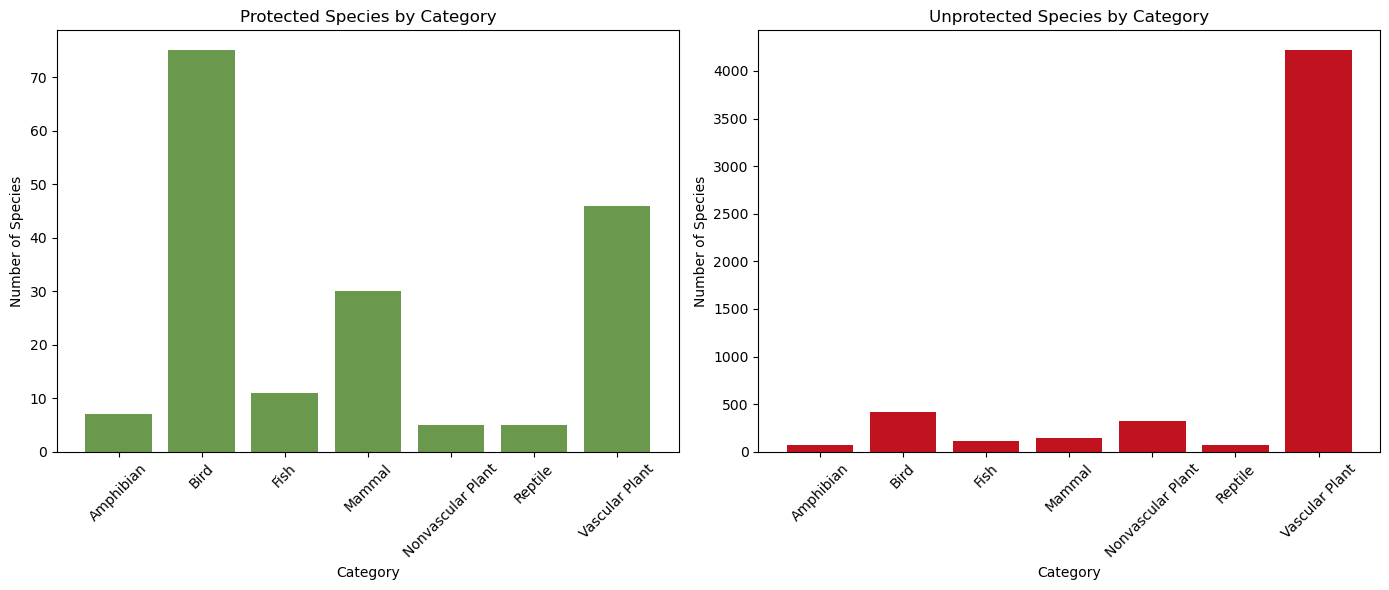

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

#'Protected' plot
ax[0].bar(conservation['Category'], conservation['Protected'], color = '#6a994e')
ax[0].set_title('Protected Species by Category')
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Number of Species')
ax[0].tick_params(axis = 'x', rotation = 45)

#'Unprotected' plot
ax[1].bar(conservation['Category'], conservation['Unprotected'], color = '#c1121f')
ax[1].set_title('Unprotected Species by Category')
ax[1].set_xlabel('Category')
ax[1].set_ylabel('Number of Species')
ax[1].tick_params(axis = 'x', rotation = 45)

plt.tight_layout()
plt.show()


### Study of species in the bird category


In [40]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)


bird_species = species[species['category'] == 'Bird'].reset_index(drop = True)

bird_common_names = (
    bird_species.common_names
    .apply(remove_punctuation)
    .str.split()
    .tolist()
)

In [41]:
clean_bird_names = [list(dict.fromkeys(name)) for name in bird_common_names]

bird_names = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in clean_bird_names))

In [42]:
bird_names_series = pd.Series(bird_names)

names_counted = (
    bird_names_series.value_counts()
    .reset_index()
)

names_counted.columns = ['Name', 'Count']

birds_df = names_counted.sort_values('Count', ascending = False)
birds_df.head()

,Name,Count
0,Warbler,59
1,Sparrow,28
2,American,21
3,Flycatcher,17
4,Northern,17


In [43]:
bird_species['is_warbler'] = bird_species['common_names'].str.contains('Warbler')

In [44]:
warbler_birds = bird_species[bird_species.is_warbler]


In [46]:
warbler_observations = (
    warbler_birds.merge(observations, on = 'scientific_name')
    .sort_values('observations', ascending = False)
    .reset_index(drop = True)
)

warbler_observations.head()

,category,scientific_name,common_names,conservation_status,protection_status,is_warbler,park_name,observations
0,Bird,Setophaga coronata,Yellow-Rumped Warbler,No Intervention,Unprotected,True,Yellowstone National Park,298
1,Bird,Helmitheros vermivorus,Worm-Eating Warbler,No Intervention,Unprotected,True,Yellowstone National Park,291
2,Bird,Dendroica pinus,Pine Warbler,No Intervention,Unprotected,True,Yellowstone National Park,284
3,Bird,Vermivora celata,Orange-Crowned Warbler,No Intervention,Unprotected,True,Yellowstone National Park,281
4,Bird,Dendroica discolor,Prairie Warbler,No Intervention,Unprotected,True,Yellowstone National Park,280


In [58]:
warbler_obs_by_park = (
    warbler_observations.groupby(['park_name', 'protection_status'])['observations']
    .sum()
    .reset_index()
)
warbler_obs_by_park

,park_name,protection_status,observations
0,Bryce National Park,Protected,195
1,Bryce National Park,Unprotected,5565
2,Great Smoky Mountains National Park,Protected,145
3,Great Smoky Mountains National Park,Unprotected,4290
4,Yellowstone National Park,Protected,492
5,Yellowstone National Park,Unprotected,13995
6,Yosemite National Park,Protected,271
7,Yosemite National Park,Unprotected,8441


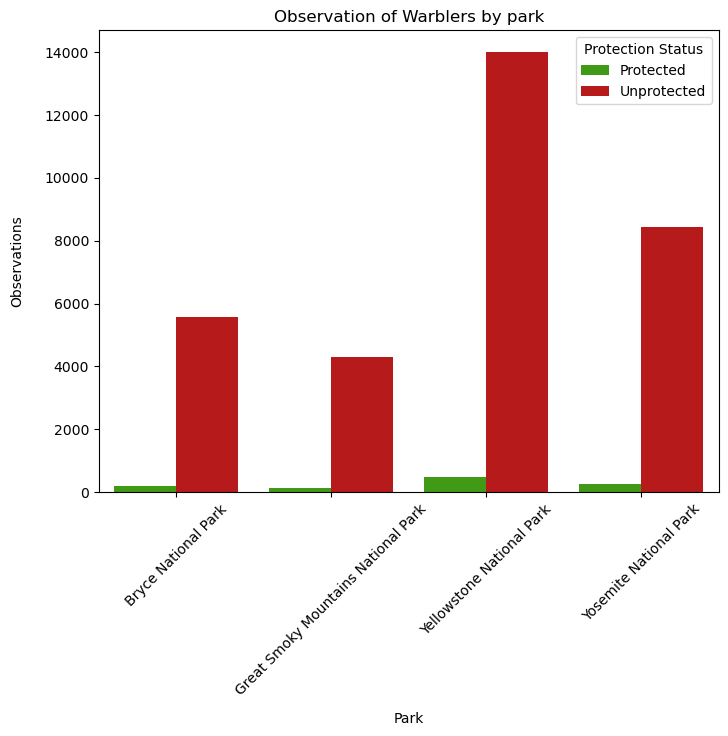

In [94]:
colors = {'Protected': '#38b000', 'Unprotected': '#d00000'}

plt.figure(figsize = (8,6))
sns.barplot(x = 'park_name', y = 'observations', hue = 'protection_status', data = warbler_obs_by_park, palette = colors )

plt.title('Observation of Warblers by park')
plt.legend(title = 'Protection Status')
plt.xlabel('Park', labelpad = 10)
plt.xticks(rotation = 45)
plt.ylabel('Observations', labelpad = 15)

plt.show()

### Conclusions
- What is the distribution of conservation status for species?
    The vast majority of species were not part of conservation programs (5,350 vs 191 species with protection status).
- Are certain types of species more likely to be endangered?
    Birds and Mammals had the highest numbers of protected species, with Birds showing the highest percentage of species under protection relative to their category size.
- Are the differences between species and their conservation status significant?
    Yes, statistical testing revealed highly significant relationships (p-value: 3.88e-05 for conservation status by category and p-value: 5.51e-89 for protection status by taxonomic category).
- Which species group is most prevalent and what is their distribution amongst parks?
    The study found that Vascular Plants occurred most frequently, comprising 4,262 species (77% of total diversity), and Yellowstone National Park showed the highest observation numbers across all categories with 1.44 million observations.
